<a href="https://colab.research.google.com/github/Jackyscy/cv/blob/main/Temperature_Spread_multistep_forecasting_direct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 5.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Load data

In [ ]:
# Same function we saw in section 2.

def load_data():

    # Data lives here.
    filename = "GT data for 3-hour intervel learning1.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    #data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["Combust Monitor Actual Spread 1"] < 35)]

    return data

In [ ]:
# Load data.

data = load_data()

data.head()

,Combust Monitor Actual Spread 1,Turb Exhaust T1,Turb Exhaust T2,Turb Exhaust T3,Turb Exhaust T4,Turb Exhaust T5,Turb Exhaust T6,Turb Exhaust T7,Turb Exhaust T8,Turb Exhaust T9,...,Combust Ref Temp,GT Compres Disch Press,GT Compres Discharge Temp,GT Compres Inlet Temp,GT Exhaust Gas Flow,GT Fuel Gas Mass Flow,GT IGV Position,GT Turbine Inlet Temp,GT Gross MW,GT Baseload Power Output Expected
Date_Time,,,,,,,,,,,,,,,,,,,,,
2021-09-05 13:50:00,31.056818,617.558472,630.641113,623.100586,624.433838,622.997681,629.324280,624.259338,613.819336,614.424744,...,1323.189209,1506.065918,409.284668,29.372759,617.549011,12.966751,87.996284,1246.550537,211.845764,229.368973
2021-09-05 16:50:00,29.123943,617.433899,627.732971,620.316772,625.417481,625.806457,631.588562,623.166626,613.281372,616.283813,...,1323.006714,1495.955322,410.848724,30.342381,616.006531,12.882809,87.994431,1247.431152,211.376907,228.132767
2021-09-05 19:50:00,29.981073,617.737305,626.815002,620.644348,626.150207,626.840393,632.476074,623.707764,613.928162,616.272095,...,1324.548096,1503.727417,410.733215,30.131554,619.785584,12.721853,87.991333,1247.777954,212.360016,228.515640
2021-09-06 10:50:00,29.942198,616.953918,624.698975,621.066834,625.358582,623.719666,631.418030,620.302856,611.742188,617.621704,...,1324.031982,1492.666870,412.803863,30.939713,611.674560,12.585037,88.001442,1248.785034,209.649109,227.099030
2021-09-06 13:50:00,27.763840,616.664490,623.856750,619.643860,624.923584,625.768555,631.285461,621.734375,612.153931,616.143250,...,1322.438599,1484.694092,412.501587,30.283035,618.603455,12.714616,88.000969,1246.161621,210.130875,227.029388


# Feature engineering steps

The same pipeline from the previous notebook.

In [ ]:
# Datetime features

dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",

    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)

In [ ]:
# Lag features.

lagf = LagFeatures(
    variables=["Combust Monitor Actual Spread 1","Turb Exhaust T1","Turb Exhaust T2",
               "Turb Exhaust T3","Turb Exhaust T4","Turb Exhaust T5",
               "Turb Exhaust T6","Turb Exhaust T7","Turb Exhaust T8"
               ,"Turb Exhaust T9","Turb Exhaust T10",
               "Turb Exhaust T11","Turb Exhaust T12","Turb Exhaust T13","Turb Exhaust T14",
               "Turb Exhaust T15","Turb Exhaust T16"
               ,"Turb Exhaust T17","Turb Exhaust T18","Turb Exhaust T19","Turb Exhaust T20",
               "Turb Exhaust T21","Turb Exhaust T22","Turb Exhaust T23","Turb Exhaust T24"
               ,"Turb Exhaust T25","Turb Exhaust T26","Turb Exhaust T27","Turb Exhaust T28",
               "Turb Exhaust T29","Turb Exhaust T30","Turb Exhaust T31","GT Exhaust Outlet Temp"
               ,"GT Exhaust Outlet temp Expected","Combust Monitor Actual Spread 2","Combust Monitor Actual Spread 3"
               ,"GT Exhaust Outlet temp Average","GT Swirl Angle"
               ,"GT Efficiency Actual (LHV)","GT Efficiency Expected (LHV)","Turbine Speed in RPM"
               ,"Combust Ref Temp","GT Compres Disch Press","GT Compres Discharge Temp","GT Compres Inlet Temp"
               ,"GT Exhaust Gas Flow","GT Fuel Gas Mass Flow","GT IGV Position"
               ,"GT Turbine Inlet Temp","GT Gross MW","GT Baseload Power Output Expected"],  # the input variables
    freq=["3H", "24H"],  # move 3 hr and 24 hrs forward
    missing_values="ignore",
)

In [ ]:
# Window features

winf = WindowFeatures(
    variables=["Combust Monitor Actual Spread 1","Turb Exhaust T1","Turb Exhaust T2",
               "Turb Exhaust T3","Turb Exhaust T4","Turb Exhaust T5",
               "Turb Exhaust T6","Turb Exhaust T7","Turb Exhaust T8"
               ,"Turb Exhaust T9","Turb Exhaust T10",
               "Turb Exhaust T11","Turb Exhaust T12","Turb Exhaust T13","Turb Exhaust T14",
               "Turb Exhaust T15","Turb Exhaust T16"
               ,"Turb Exhaust T17","Turb Exhaust T18","Turb Exhaust T19","Turb Exhaust T20",
               "Turb Exhaust T21","Turb Exhaust T22","Turb Exhaust T23","Turb Exhaust T24"
               ,"Turb Exhaust T25","Turb Exhaust T26","Turb Exhaust T27","Turb Exhaust T28",
               "Turb Exhaust T29","Turb Exhaust T30","Turb Exhaust T31","GT Exhaust Outlet Temp"
               ,"GT Exhaust Outlet temp Expected","Combust Monitor Actual Spread 2","Combust Monitor Actual Spread 3"
               ,"GT Exhaust Outlet temp Average","GT Swirl Angle"
               ,"GT Efficiency Actual (LHV)","GT Efficiency Expected (LHV)","Turbine Speed in RPM"
               ,"Combust Ref Temp","GT Compres Disch Press","GT Compres Discharge Temp","GT Compres Inlet Temp"
               ,"GT Exhaust Gas Flow","GT Fuel Gas Mass Flow","GT IGV Position"
               ,"GT Turbine Inlet Temp","GT Gross MW","GT Baseload Power Output Expected"],  # the input variables
    window="9H",  # average of 9 previous hours
    freq="3H",  # move 3 hr forward
    missing_values="ignore",
)

In [ ]:
# Periodic features

#cyclicf = CyclicalFeatures(
    # The features we want to transform.
    #variables=["month", "hour"],
    # Whether to drop the original features.
    #drop_original=False,
)

In [ ]:
# Drop missing data
imputer = DropMissingData()

In [ ]:
# Drop original time series

drop_ts = DropFeatures(features_to_drop=["Combust Monitor Actual Spread 1","Turb Exhaust T1","Turb Exhaust T2",
               "Turb Exhaust T3","Turb Exhaust T4","Turb Exhaust T5",
               "Turb Exhaust T6","Turb Exhaust T7","Turb Exhaust T8"
               ,"Turb Exhaust T9","Turb Exhaust T10",
               "Turb Exhaust T11","Turb Exhaust T12","Turb Exhaust T13","Turb Exhaust T14",
               "Turb Exhaust T15","Turb Exhaust T16"
               ,"Turb Exhaust T17","Turb Exhaust T18","Turb Exhaust T19","Turb Exhaust T20",
               "Turb Exhaust T21","Turb Exhaust T22","Turb Exhaust T23","Turb Exhaust T24"
               ,"Turb Exhaust T25","Turb Exhaust T26","Turb Exhaust T27","Turb Exhaust T28",
               "Turb Exhaust T29","Turb Exhaust T30","Turb Exhaust T31","GT Exhaust Outlet Temp"
               ,"GT Exhaust Outlet temp Expected","Combust Monitor Actual Spread 2","Combust Monitor Actual Spread 3"
               ,"GT Exhaust Outlet temp Average","GT Swirl Angle"
               ,"GT Efficiency Actual (LHV)","GT Efficiency Expected (LHV)","Turbine Speed in RPM"
               ,"Combust Ref Temp","GT Compres Disch Press","GT Compres Discharge Temp","GT Compres Inlet Temp"
               ,"GT Exhaust Gas Flow","GT Fuel Gas Mass Flow","GT IGV Position"
               ,"GT Turbine Inlet Temp","GT Gross MW","GT Baseload Power Output Expected"])

# Feature engineering pipeline

In [ ]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        #("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

# Split data into train and test

We will evaluate the performance of the model in a test set consisting of the last month of data.

In [ ]:
# Check data span:

data.index.min(), data.index.max()

(Timestamp('2021-09-05 13:50:00'), Timestamp('2023-09-05 13:50:00'))

Due to our 24h lag feature, we need data about the pollutant information at least 24 hours before the first forecasting point in the test set to create input features.

Thus, the test set must contain the first forecasting point plus the previous 24 hours.

In [ ]:
# The last month of data begins on 2023-08-5.

# But we need 24 hr of prior data to create
# the necessary features:

pd.Timestamp("2023-08-05") - pd.offsets.Hour(24)

Timestamp('2023-08-04 00:00:00')

In [ ]:
# Split the data.

# input data
X_train = data[data.index < "2023-08-5"]
X_test = data[data.index >= pd.Timestamp("2023-08-5") - pd.offsets.Hour(24)]

# target
y_train = data[data.index < "2023-08-5"]["Combust Monitor Actual Spread 1"]
y_test = data[data.index >= pd.Timestamp("2023-08-5") - pd.offsets.Hour(24)][
    "Combust Monitor Actual Spread 1"
]

In [ ]:
# Let's check that we have the correct data span
# in the test set:

X_test.index.min(), X_test.index.max()

(Timestamp('2023-08-11 01:50:00'), Timestamp('2023-09-05 13:50:00'))

# Train pipeline and model

We train the engineering steps and the pipeline utilizing the training set.

In [ ]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,Combust Monitor Actual Spread 1_lag_3H,Turb Exhaust T1_lag_3H,Turb Exhaust T2_lag_3H,Turb Exhaust T3_lag_3H,...,Combust Ref Temp_window_9H_mean,GT Compres Disch Press_window_9H_mean,GT Compres Discharge Temp_window_9H_mean,GT Compres Inlet Temp_window_9H_mean,GT Exhaust Gas Flow_window_9H_mean,GT Fuel Gas Mass Flow_window_9H_mean,GT IGV Position_window_9H_mean,GT Turbine Inlet Temp_window_9H_mean,GT Gross MW_window_9H_mean,GT Baseload Power Output Expected_window_9H_mean
Date_Time,,,,,,,,,,,,,,,,,,,,,
2021-09-06 13:50:00,9,36,0,6,13,0,29.942198,616.953918,624.698975,621.066834,...,1324.031982,1492.666870,412.803863,30.939713,611.674560,12.585037,88.001442,1248.785034,209.649109,227.099030
2021-09-06 16:50:00,9,36,0,6,16,0,27.763840,616.664490,623.856750,619.643860,...,1323.235291,1488.680481,412.652725,30.611374,615.139008,12.649827,88.001205,1247.473327,209.889992,227.064209
2021-09-06 19:50:00,9,36,0,6,19,0,28.914980,617.826111,627.147278,622.351929,...,1322.041545,1489.692871,412.352173,30.743567,615.180359,12.665601,88.001956,1247.047851,209.853312,226.963328
2021-09-07 13:50:00,9,36,1,7,13,0,30.817898,619.331543,624.586365,622.287293,...,1319.948120,1487.434937,413.095429,31.207663,611.089233,12.723558,88.007751,1247.594604,209.116882,226.831329
2021-09-07 16:50:00,9,36,1,7,16,0,26.917515,611.400207,618.744446,612.412842,...,1314.361939,1484.415710,412.834976,31.727675,609.653626,12.571490,87.819294,1241.908874,207.130745,225.901825


In [ ]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(2875,)
(1998,)


In [ ]:
from sklearn.linear_model import Ridge , Lasso , ElasticNet , LinearRegression

In [ ]:
model_Lasso_alpha = Lasso(alpha = 0.5)
model_Lasso_alpha.fit(X_train_t , y_train_t)
print(" Training Accuracy : " , model_Lasso_alpha.score(X_train_t , y_train_t))
#print(" Testing Accuracy : " , model_Lasso_alpha.score(X_test_t , y_test_t))

 Training Accuracy :  0.31059596413595925


In [ ]:
import pandas as pd
import numpy as np


Text(0, 0.5, 'Importance')

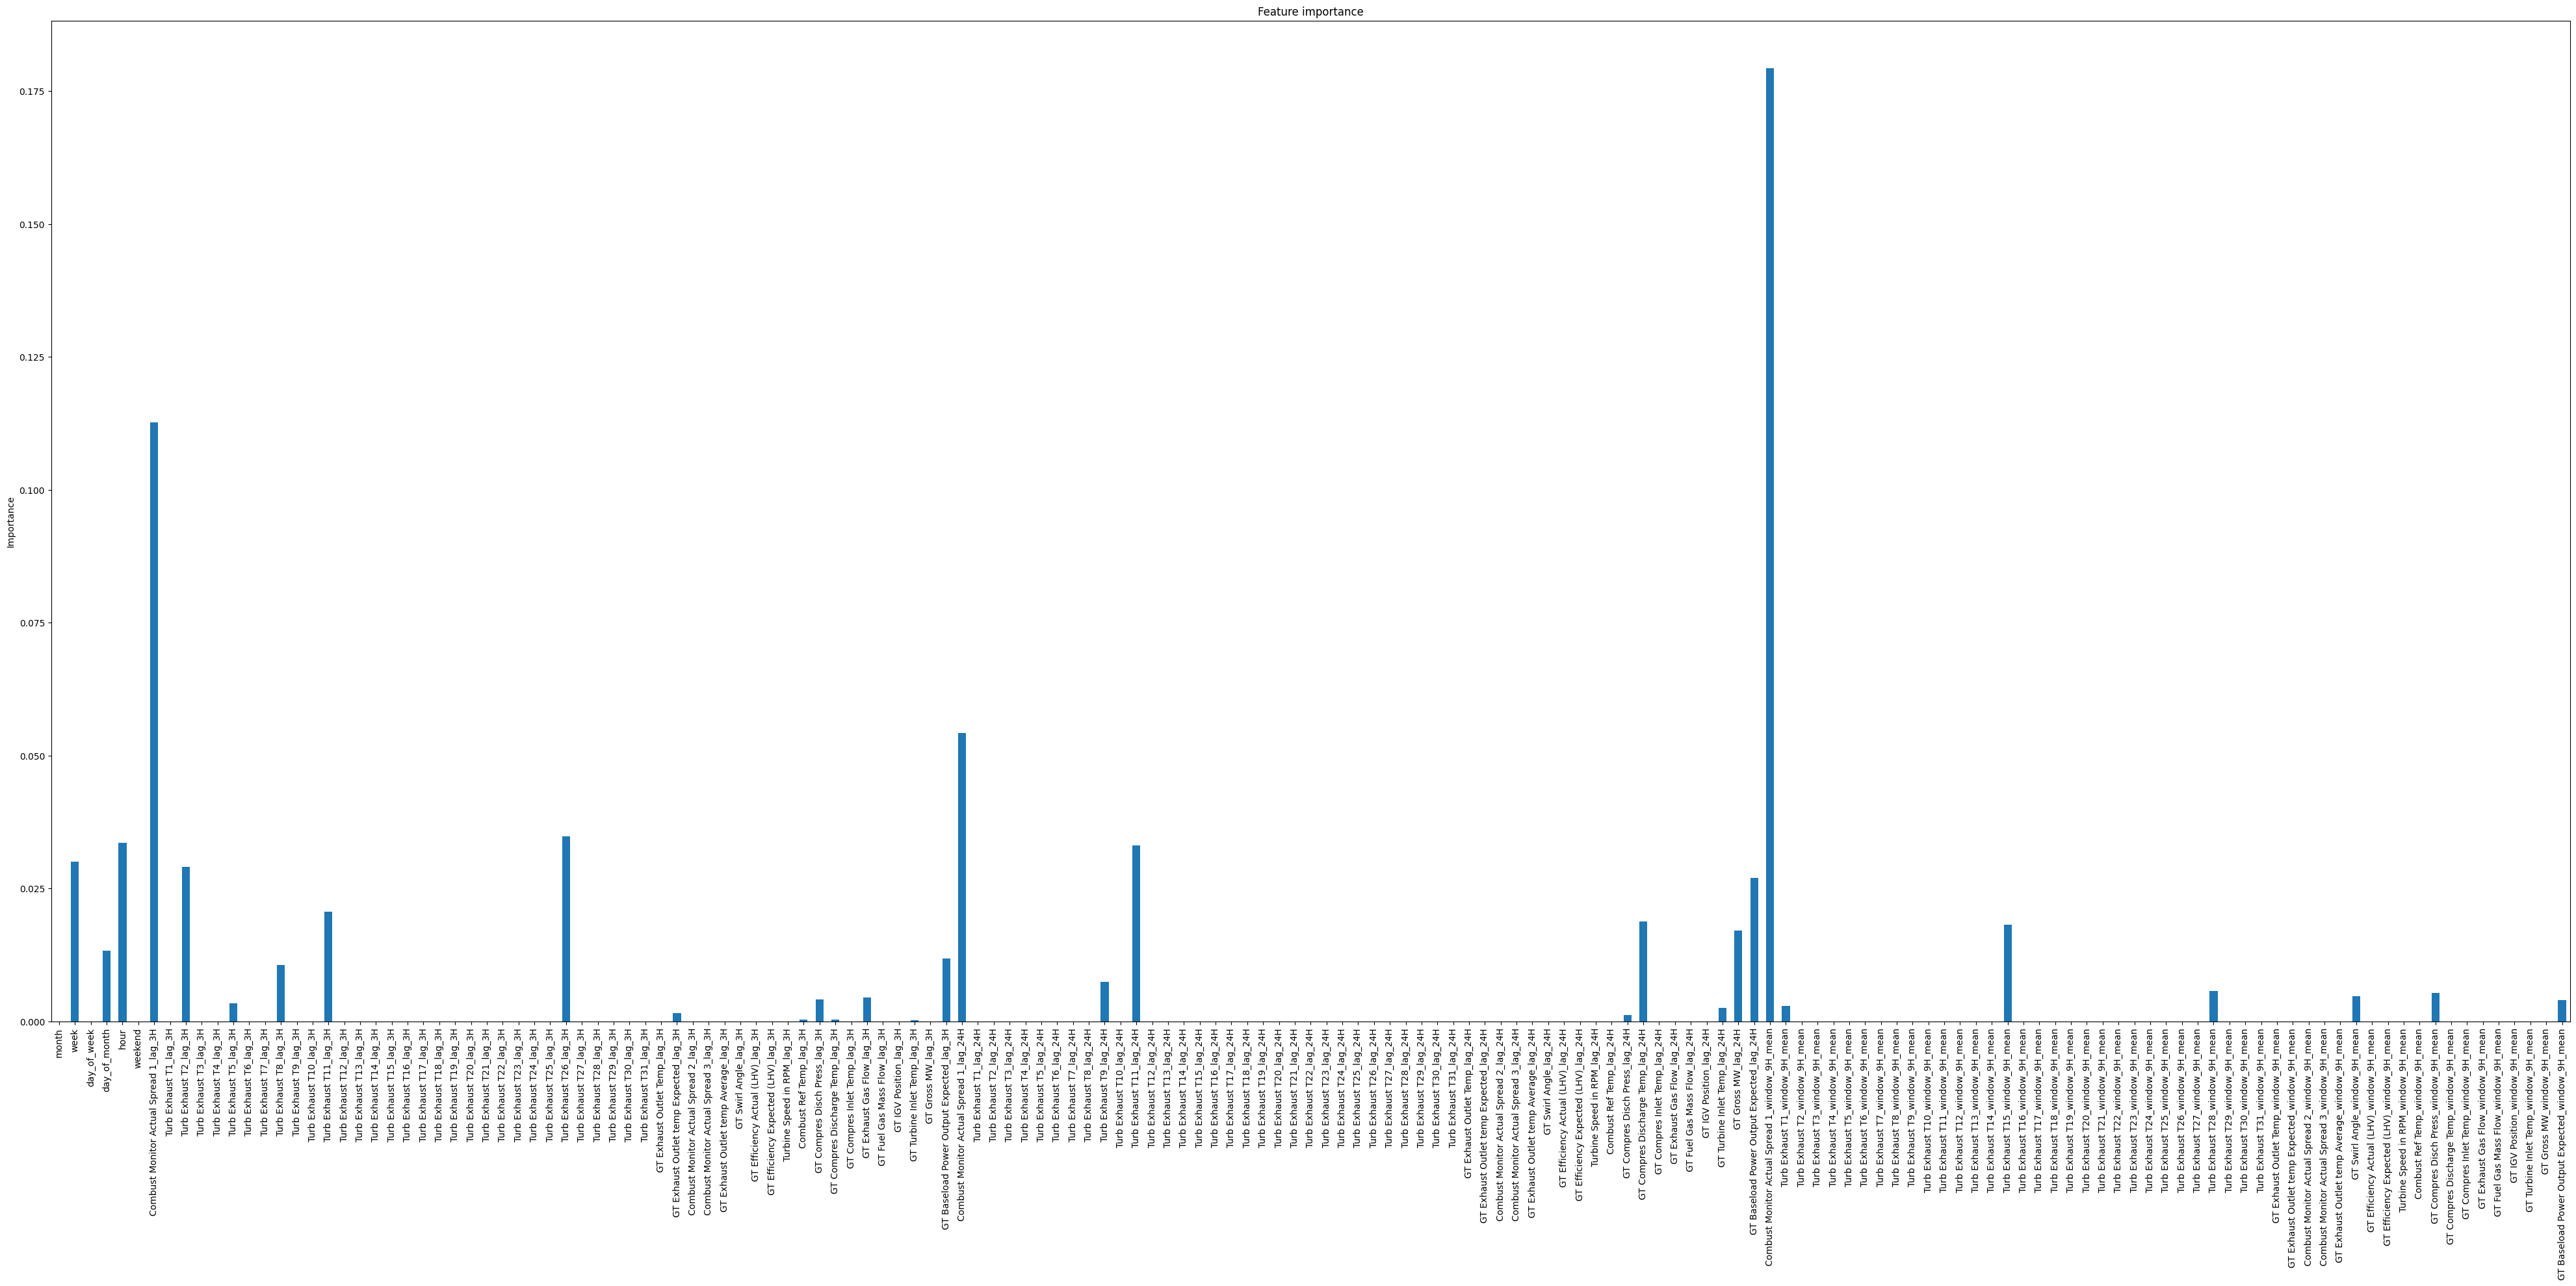

In [ ]:
# Let's now plot the feature's importance
# according to the Lasso model.

# Create series with feature importance.
tmp = pd.Series(np.abs(model_Lasso_alpha.coef_))

# Let's add the variable names.
Xtrain = pd.DataFrame(X_train_t)
tmp.index = Xtrain.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(50, 20))
plt.title("Feature importance")
plt.ylabel("Importance")

In [ ]:
# Lasso regression

model = Ridge()
model.fit(X_train_t, y_train_t)

#lasso = Lasso(random_state=0)

# Train the model

#lasso.fit(X_train_t, y_train_t)

Ridge()

In [ ]:
# Make predictions

preds = model.predict(X_train_t)

preds

array([28.38934838, 28.2311072 , 29.42526735, ..., 28.64577151,
       29.59657344, 30.78351351])

Text(0.5, 1.0, 'Forecast: train set')

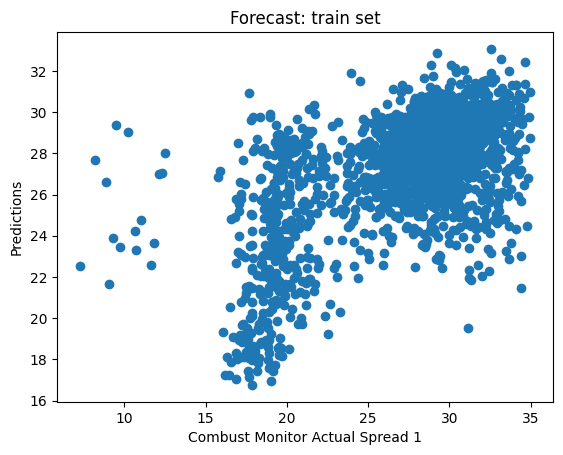

In [ ]:
# Plot the predictions vs the truth.

plt.scatter(y_train_t, preds)
plt.xlabel("Combust Monitor Actual Spread 1")
plt.ylabel("Predictions")
plt.title("Forecast: train set")

In [ ]:
# The RMSE in the train set.

mean_squared_error(preds, y_train_t, squared=False)

3.733012959814649

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Text(0, 0.5, 'Importance')

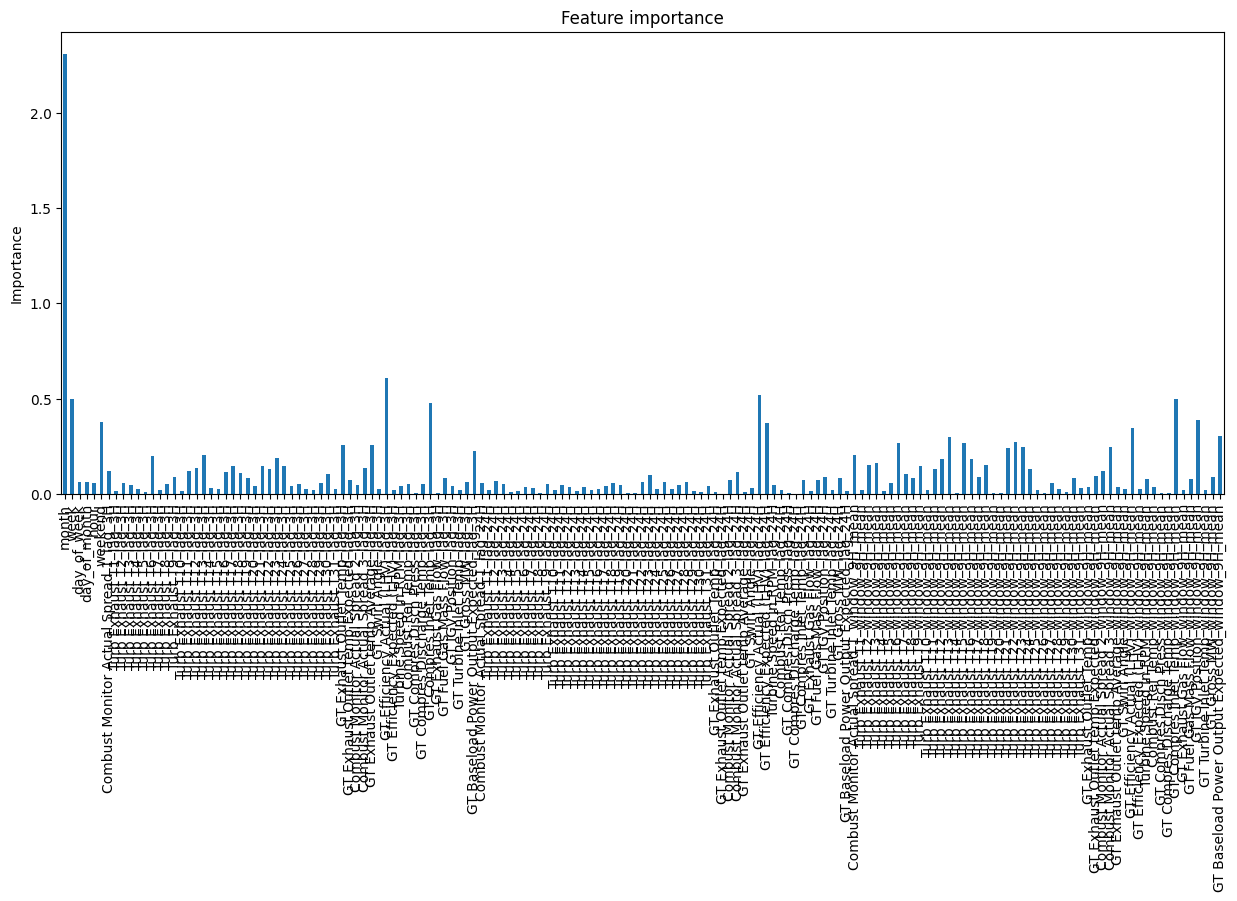

In [ ]:
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(model.coef_))

# Let's add the variable names.
tmp.index = X_train_t.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")

On the train set, the model seems to be doing a decent job.

# Evaluate model

We will evaluate the performance of the model in our test set now.

In [ ]:
# Create the input features:

X_test_t = pipe.transform(X_test)

X_test_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,RH_lag_1H,CO_sensor_lag_24H,RH_lag_24H,CO_sensor_window_3H_mean,RH_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,,,,
2005-03-04 00:00:00,3,9,4,4,0,0,1179.0,82.0,1047.0,41.7,1223.333333,82.700000,1.0,6.123234e-17,0.000000,1.000000
2005-03-04 01:00:00,3,9,4,4,1,0,929.0,37.4,1030.0,43.3,1104.666667,67.300000,1.0,6.123234e-17,0.269797,0.962917
2005-03-04 02:00:00,3,9,4,4,2,0,951.0,40.8,986.0,45.9,1019.666667,53.400000,1.0,6.123234e-17,0.519584,0.854419
2005-03-04 03:00:00,3,9,4,4,3,0,938.0,44.2,992.0,49.7,939.333333,40.800000,1.0,6.123234e-17,0.730836,0.682553
2005-03-04 04:00:00,3,9,4,4,4,0,921.0,48.7,1076.0,56.3,936.666667,44.566667,1.0,6.123234e-17,0.887885,0.460065


In [ ]:
# Note that the prior 24 hr of information
# dissapeared from our test set (they had null data).

# Our dataset contains the first forecasting point
# as expected.

X_test_t.index.min(), X_test_t.index.max()

(Timestamp('2005-03-04 00:00:00'), Timestamp('2005-04-04 14:00:00'))

In [ ]:
# Make predictions.

preds = lasso.predict(X_test_t)

preds[0:10]

array([1122.2269227 ,  855.95634311,  910.00549256,  931.51941646,
        929.00244686,  868.51544281,  849.8519462 ,  907.782453  ,
        972.14913519, 1006.27472793])

In [ ]:
print(y_test.shape)

# Adjust the target, it has observations
# that were removed from the test set due
# to null values.

y_test_t = y_test.loc[X_test_t.index]

print(y_test_t.shape)

(567,)
(495,)


Text(0.5, 1.0, 'Forecast: test set')

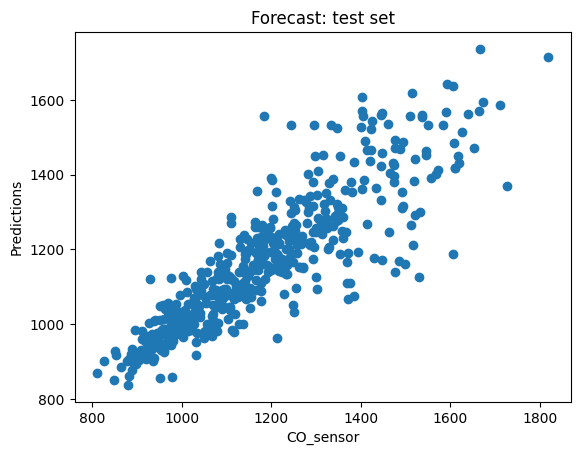

In [ ]:
# Plot the predictions vs the truth.

plt.scatter(y_test_t, preds)
plt.xlabel("CO_sensor")
plt.ylabel("Predictions")
plt.title("Forecast: test set")

In [ ]:
# RMSE in test set

mean_squared_error(preds, y_test_t, squared=False)

95.4141631246702

We see that our linear regression makes fairly good predictions of the pollutant concentration in the next hour.